In [1]:
cd /Data1/hmd2/notebooks_th/AttnLSTM_exp

/Data1/hmd2/notebooks_th/AttnLSTM_exp


In [2]:
import torch 
import torch.nn.functional as F
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from model import MHA_LSTM


import config
from dataset import Stronglabeled_Dataset, recording_df


Training with 751 patients!



/opt/conda/lib/python3.10/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


In [3]:
def load_student_teacher_both(model_folder: pathlib.Path, model_name: str):
    student, teacher = eval(model_name)(), eval(model_name)()
    student.load_state_dict(torch.load(pathlib.Path(model_folder) / "Best_student.pt"))
    teacher.load_state_dict(torch.load(pathlib.Path(model_folder) / "Best_teacher.pt"))
    return student, teacher

model = MHA_LSTM()
model_folder = "/Data1/hmd2/notebooks_th/AttnLSTM/exps/2024-10-24_18:11:50"
model_name = type(model).__name__
student, teacher = load_student_teacher_both(model_folder, model_name)

In [4]:
full_dataset = Stronglabeled_Dataset(config.train_data, 
                                     recording_df.index, recording_df.murmur_timing, 
                            recording_df.patient_murmur_label, recording_df.outcome_label,
                            sampling_rate= config.sampling_rate,
                            window_length= config.window_length,
                            window_step= config.hop_length,
                            freq_bins= None,
                            clean_noise= False, #config.clean_noise,
                            slice_feature= False,
                            sequence_length= config.sequence_length)

In [5]:
holosys_label, earlysys_label, midsys_label = None, None, None

for idx, (mel, seq_label, mm_label, oc_label, wav_len, filename ) in enumerate(full_dataset):
    if filename == "9979_AV":
       holo_mel, holosys_label =  mel, seq_label
    if filename == "14241_AV":
        earlysys_mel, earlysys_label = mel, seq_label
    if filename == "46065_AV":
        midsys_mel, midsys_label = mel, seq_label
    if filename == "43852_MV":
        clean_mel, clean_label = mel, seq_label
    if holosys_label is not None and earlysys_label is not None and midsys_label is not None:
        break
    
holosys_label.shape, earlysys_label.shape, midsys_label.shape

(torch.Size([3, 906]), torch.Size([3, 1022]), torch.Size([3, 785]))

In [8]:
tensor_np.shape

(3, 1022)

In [11]:
tensor_np[:, 100: 400].shape

(3, 300)

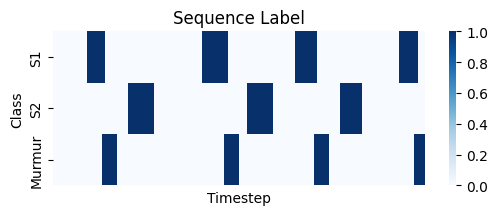

In [35]:
tensor_np = earlysys_label.numpy()

C, T = tensor_np.shape

class_list = ["S1", "S2", "Murmur"]

# 히트맵 그리기
plt.figure(figsize=(6, 2))
sns.heatmap(tensor_np[:,  500 : 600], cmap="Blues", cbar=True, xticklabels=False, yticklabels=[f'{class_list[i]}' for i in range(C)])
plt.title("Sequence Label")
plt.xlabel("Timestep")
plt.ylabel("Class")
# plt.yticks(rotation=0)
plt.show()

In [36]:
holosys_seq_pred_tch, _ = teacher(earlysys_mel.unsqueeze(0))
holosys_seq_pred_tch = F.sigmoid(holosys_seq_pred_tch).squeeze(0)

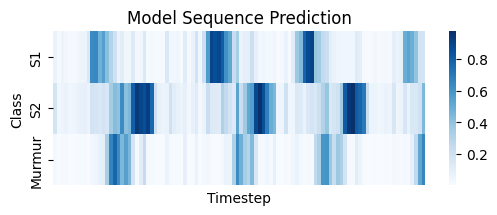

In [40]:
tensor_np = holosys_seq_pred_tch.detach().numpy()

C, T = tensor_np.shape

class_list = ["S1", "S2", "Murmur"]

# 히트맵 그리기
plt.figure(figsize=(6, 2))
sns.heatmap(tensor_np[:, 500: 600], cmap="Blues", cbar=True, xticklabels=False, yticklabels=[f'{class_list[i]}' for i in range(C)])
plt.title("Sequence Label")
plt.title("Model Sequence Prediction")
plt.xlabel("Timestep")
plt.ylabel("Class")
plt.show()

In [ ]:
tensor_np = clean_label.numpy()

C, T = tensor_np.shape

# 히트맵 그리기
plt.figure(figsize=(8, 4))
sns.heatmap(tensor_np, cmap="Blues", cbar=True, xticklabels=False, yticklabels=[f'Class {i}' for i in range(C)])
plt.title("Clean_seq_labels")
plt.xlabel("Timestep")
plt.ylabel("Class")
plt.show()

In [ ]:
clean_seq_pred_tch, clean_mm_pred = teacher(clean_mel.unsqueeze(0))
clean_mm_pred = F.softmax(clean_mm_pred, dim= -1)
clean_seq_pred_tch = F.sigmoid(clean_seq_pred_tch).squeeze(0)

tensor_np = clean_seq_pred_tch.detach().numpy()

C, T = tensor_np.shape

# 히트맵 그리기
plt.figure(figsize=(8, 4))
sns.heatmap(tensor_np, cmap="Blues", cbar=True, xticklabels=False, yticklabels=[f'Class {i}' for i in range(C)])
plt.title("Holosystolic_seq_labels")
plt.xlabel("Timestep")
plt.ylabel("Class")
plt.show()